In [3]:
# Full imports
import gym
import cv2

# Partial imports
from gym import spaces
from math import cos, sin, pi

# Aliased imports
import numpy as np
import matplotlib.pyplot as plt


In [4]:
class TelesketchEnv(gym.Env):
    metadata = {"render_modes": ["image"]}

    def __init__(self, ref_canvas, sim_func, segment_length=5, stroke_thickness=5, render_mode=None) -> None:
        # Save ref image & sim func
        self.ref_canvas = self._to_norm_gray(ref_canvas)
        self.sim_func = sim_func
        self._reset_called = False

        # Save segment params
        self.segment_length = segment_length
        self.stroke_thickness = stroke_thickness
        
        # Define action space
        self.action_space = spaces.Discrete(8)

        # Define observation space
        self.observation_space = spaces.Dict(
            {
                "loc": spaces.Box(np.array((0, 0)), np.array(self.ref_canvas.shape), dtype=int),
                "canvas": spaces.Box(0, 255, shape=self.ref_canvas.shape, dtype=np.float32)
            }
        )

        # Assert correct render mode is selected
        assert render_mode is None or render_mode in self.metadata["render_modes"], "{render_mode} not supported"
        self.render_mode = render_mode

        self.window = None
        self.clock = None

    def _to_norm_gray(self, img):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return img.astype(np.float32) / 255

    def _get_obs(self):
        return {"loc": self._loc, "canvas": self._canvas}
    
    def _get_info(self):
        return {"sim": self.sim_func(self._canvas, self.ref_canvas)}

    def _compute_rewards(self, ref_canvas, new_canvas, old_canvas):
        old_sim = self.sim_func(ref_canvas, old_canvas)
        new_sim = self.sim_func(ref_canvas, new_canvas)

        return 1 if new_sim > old_sim else 0
 
    def reset(self, loc=(0, 0), seed=None,):
        super().reset(seed=seed)

        self._loc = np.array(loc)
        self._canvas = np.full(self.ref_canvas.shape, 1, dtype=np.float32)
        
        # Reset flag
        self._reset_called = True

        return self._get_obs(), self._get_info()
    
    def step(self, action):
        # Check action is correct and reset has been called
        assert action >= 0 and action < self.action_space.n, "Action is not valid"
        assert self._reset_called, "Reset must be called before step"

        # Compute target x, y
        x = cos(action * pi / 4) * self.segment_length
        y = sin(action * pi / 4) * self.segment_length

        # Compute new states
        new_loc = self._loc + np.round(np.array([x, -y])).astype(int)

        new_canvas = cv2.line(self._canvas, self._loc, new_loc, (0, 0, 0), self.stroke_thickness)

        # Compute rewards
        reward = self._compute_rewards(self.ref_canvas, new_canvas, self._canvas)

        # Update state
        self._loc = new_loc
        self._canvas = new_canvas

        return self._get_obs(), reward, None, False, self._get_info()

    def render(self):
        if self.render_mode == "image":
            self._plt_render()

    def _plt_render(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

        ref = cv2.cvtColor((self.ref_canvas * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
        gen = cv2.cvtColor((self._canvas * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

        ax1.imshow(ref, cmap="gray")
        ax2.imshow(gen, cmap="gray")

        ax1.set_title("Ref. Canvas")
        ax2.set_title("Env. Canvas")

        plt.show() 

In [5]:
# Ref canvas
ref_canvas = np.full((250, 250, 3), 255, dtype=np.uint8)
ref_canvas = cv2.line(ref_canvas, (0, 0), (250, 250), (0, 0, 0), 5)

# Sim func
def rmse_sim(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

In [6]:
# Init env
env = TelesketchEnv(ref_canvas, rmse_sim, 20, 5, "image")
env.reset((125, 125))

({'loc': array([125, 125]),
  'canvas': array([[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)},
 {'sim': 47.222878})

In [74]:
PATCH_SIZE = (31, 31)

def patch(canvas: np.ndarray, loc: np.ndarray, size) -> np.ndarray:
    # Define square patch
    xmin = np.clip(int(loc[0] - np.floor(size[0] / 2)), 0, canvas.shape[0])
    xmax = np.clip(int(loc[0] + np.floor(size[0] / 2)), 0, canvas.shape[0])
    ymin = np.clip(int(loc[1] - np.floor(size[0] / 2)), 0, canvas.shape[1])
    ymax = np.clip(int(loc[1] + np.floor(size[0] / 2)), 0, canvas.shape[1])

    # Get patch
    img = canvas[xmin:xmax, ymin:ymax]
    padding = [
        # Top, bottom
        (0, size[1] - img.shape[1]),
        # Right, left
        (0, size[0] - img.shape[0])
    ]
    
    return img
    #return np.pad(img, padding, mode="constant", constant_values=1)

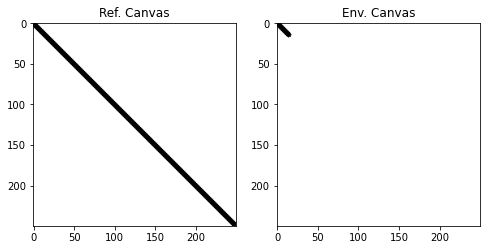

In [75]:
env.reset()
state, _, _, _, _ = env.step(7)
loc = state["loc"]
canvas = state["canvas"]
env.render()


In [79]:
ref = cv2.cvtColor(ref_canvas, cv2.COLOR_BGR2GRAY)
ref = ref.astype(np.float32) / 255

img = patch(ref_canvas, [240, 240], (31, 31))
img.shape

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [78]:

img = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

plt.imshow(img, cmap="gray")

error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<1>; VDcn = cv::impl::{anonymous}::Set<3, 4>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 3


In [58]:
np.resize(img, (32, 32))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)